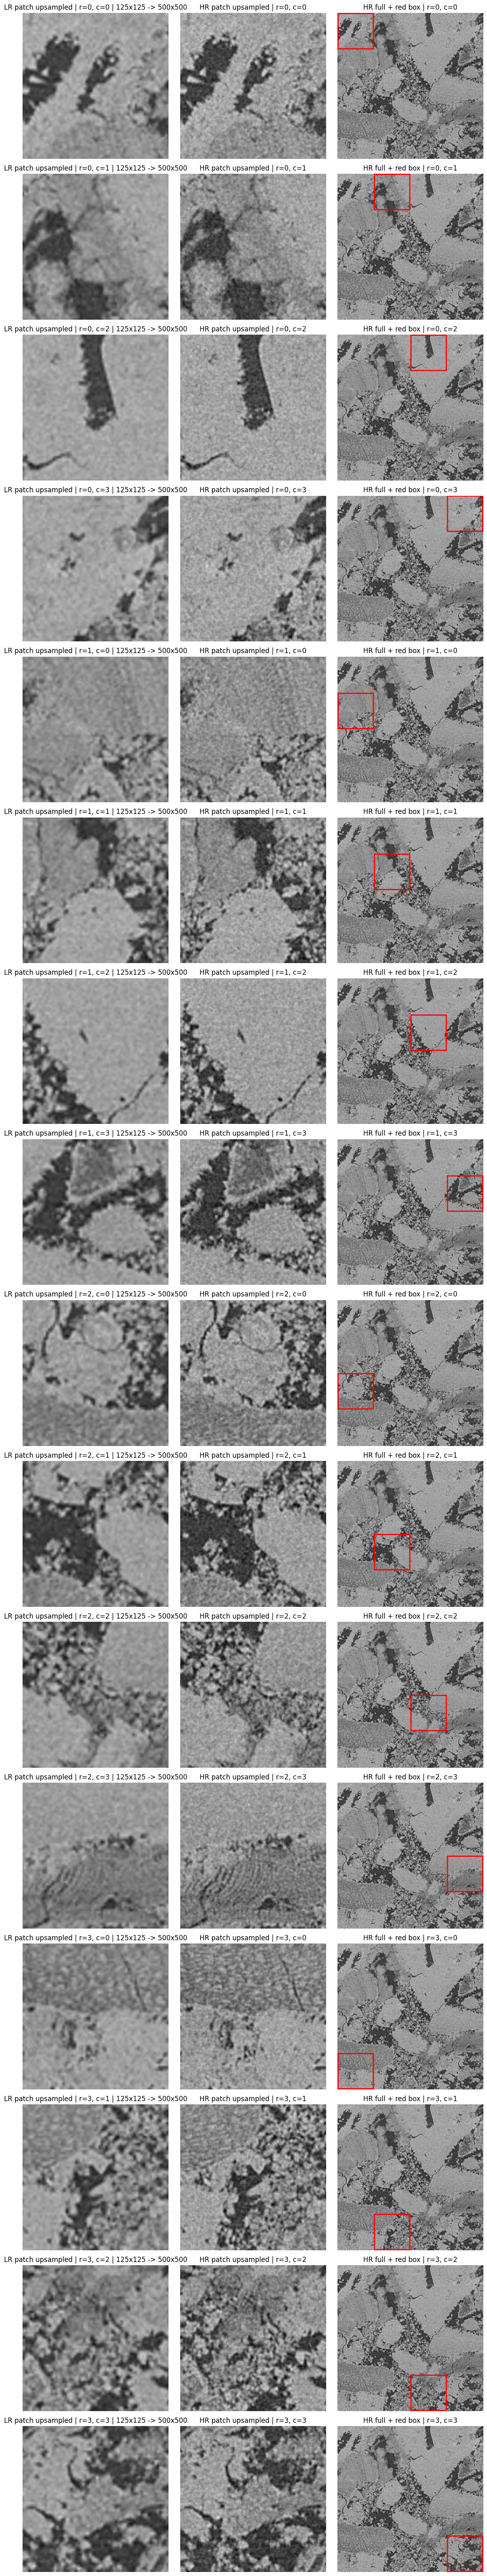

In [1]:
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


# ============ НАСТРОЙКИ ============
LR_DIR = Path('C:/Users/Вячеслав/Documents/superresolution/DeepRockSR-2D/carbonate2D/carbonate2D_test_LR_default_X2')
HR_DIR = Path('C:/Users/Вячеслав/Documents/superresolution/DeepRockSR-2D/carbonate2D/carbonate2D_test_HR')

GRID = 4                      # 4x4 = 16 патчей
UPSAMPLE_TO = (500, 500)      # как показывать каждый патч
PATCH_RESAMPLE = Image.NEAREST  # NEAREST для "чётких" пикселей; можно Image.BICUBIC
LR_TO_HR_RESAMPLE = Image.BICUBIC
RECT_COLOR = (255, 0, 0)      # красный
RECT_WIDTH = 4
# ==================================


def load_image(path: Path) -> Image.Image:
    """Загружает изображение. Для CT обычно лучше L (grayscale), но оставим авто."""
    img = Image.open(path)
    # Если у тебя точно grayscale — можешь раскомментировать:
    # img = img.convert("L")
    return img


def ensure_same_size(lr: Image.Image, hr: Image.Image) -> Image.Image:
    """Если LR не совпадает по размеру с HR — ресайзим LR до HR (чтобы патчи совпали по координатам)."""
    if lr.size != hr.size:
        lr = lr.resize(hr.size, LR_TO_HR_RESAMPLE)
    return lr


def draw_patch_rect(hr_full: Image.Image, x0: int, y0: int, x1: int, y1: int) -> Image.Image:
    """Возвращает копию HR full с красной рамкой патча."""
    img = hr_full.copy()
    # Если картинка в L (grayscale), то для цветной рамки надо перевести в RGB:
    if img.mode != "RGB":
        img = img.convert("RGB")
    draw = ImageDraw.Draw(img)
    draw.rectangle([x0, y0, x1 - 1, y1 - 1], outline=RECT_COLOR, width=RECT_WIDTH)
    return img

import re
from pathlib import Path

SCALE_RE = re.compile(r'([_-]?)x(\d+)$', re.IGNORECASE)

def lr_to_base_stem(lr_stem: str) -> str:
    """
    Преобразует stem LR (без расширения) в базовый stem (как у HR).
    Примеры:
      '3607x2'   -> '3607'
      '3607_x2'  -> '3607'
      '3607-x4'  -> '3607'
    """
    return SCALE_RE.sub('', lr_stem)

def find_hr_for_lr(lr_path: Path, hr_dir: Path) -> Path:
    """
    Находит HR-файл по LR-файлу.
    Ищем HR с любым расширением, но с stem == base.
    """
    base = lr_to_base_stem(lr_path.stem)

    # все кандидаты в HR с таким же stem
    candidates = [p for p in hr_dir.iterdir() if p.is_file() and p.stem == base]

    if len(candidates) == 0:
        raise FileNotFoundError(f"Не найден HR для LR={lr_path.name}. Ожидался stem='{base}' в {hr_dir}")
    if len(candidates) > 1:
        # если несколько расширений (png/tif/jpg) — лучше явно выбрать правило
        raise RuntimeError(f"Найдено несколько HR-кандидатов для '{base}': {[c.name for c in candidates]}")

    return candidates[0]

def find_lr_for_hr(hr_path: Path, lr_dir: Path, scale: int = 2) -> Path:
    """
    Обратное: находит LR по HR, ожидая суффикс x{scale}.
    """
    stem = f"{hr_path.stem}x{scale}"
    candidates = [p for p in lr_dir.iterdir() if p.is_file() and p.stem == stem]
    if len(candidates) == 0:
        # пробуем варианты с _ и -
        for sep in ["_", "-"]:
            alt_stem = f"{hr_path.stem}{sep}x{scale}"
            candidates = [p for p in lr_dir.iterdir() if p.is_file() and p.stem == alt_stem]
            if candidates:
                break

    if len(candidates) == 0:
        raise FileNotFoundError(f"Не найден LR для HR={hr_path.name} (scale x{scale}) в {lr_dir}")
    if len(candidates) > 1:
        raise RuntimeError(f"Найдено несколько LR-кандидатов: {[c.name for c in candidates]}")
    return candidates[0]



def show_16_patch_rows(lr_img: Image.Image, hr_img: Image.Image, grid: int = 4):
    W, H = hr_img.size
    assert W % grid == 0 and H % grid == 0, f"HR размер {W}x{H} должен делиться на GRID={grid}"
    pw, ph = W // grid, H // grid

    # Подготовим фигуру: 16 строк x 3 столбца
    fig, axes = plt.subplots(grid * grid, 3, figsize=(12, 4 * grid * grid))
    if grid * grid == 1:
        axes = [axes]  # на всякий случай

    idx = 0
    for r in range(grid):
        for c in range(grid):
            x0, y0 = c * pw, r * ph
            x1, y1 = x0 + pw, y0 + ph

            lr_patch = lr_img.crop((x0, y0, x1, y1)).resize(UPSAMPLE_TO, PATCH_RESAMPLE)
            hr_patch = hr_img.crop((x0, y0, x1, y1)).resize(UPSAMPLE_TO, PATCH_RESAMPLE)

            hr_full_box = draw_patch_rect(hr_img, x0, y0, x1, y1)

            # --- отрисовка строки ---
            ax0, ax1, ax2 = axes[idx]

            ax0.imshow(lr_patch, cmap="gray" if lr_patch.mode == "L" else None)
            ax0.set_title(f"LR patch upsampled | r={r}, c={c} | {pw}x{ph} -> {UPSAMPLE_TO[0]}x{UPSAMPLE_TO[1]}")
            ax0.axis("off")

            ax1.imshow(hr_patch, cmap="gray" if hr_patch.mode == "L" else None)
            ax1.set_title(f"HR patch upsampled | r={r}, c={c}")
            ax1.axis("off")

            ax2.imshow(hr_full_box, cmap="gray" if hr_full_box.mode == "L" else None)
            ax2.set_title(f"HR full + red box | r={r}, c={c}")
            ax2.axis("off")

            idx += 1

    plt.tight_layout()
    plt.show()


# ============ ЗАПУСК ============
lr_path = LR_DIR / "3607x2.png"
hr_path = find_hr_for_lr(lr_path, HR_DIR)

lr = load_image(lr_path)
hr = load_image(hr_path)
lr = ensure_same_size(lr, hr)

show_16_patch_rows(lr, hr, grid=4)

In [17]:
import torch
from pathlib import Path
from PIL import Image
import numpy as np

# --------------------
# настройки
# --------------------
MODEL_PT = Path("C:/Users/Вячеслав/Documents/superresolution/models/test_2_x2_msresunet.pt")
IMG_PATH = Path('C:/Users/Вячеслав/Documents/superresolution/DeepRockSR-2D/carbonate2D/carbonate2D_test_LR_default_X2/3607x2.png')
OUT_PATH = Path('C:/Users/Вячеслав/Documents/superresolution/sr.png')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# если у тебя grayscale SR: C=1; если RGB: C=3
FORCE_GRAYSCALE = True

# нормализация: чаще всего для SR используют [0,1]
# если при обучении делал mean/std — нужно повторить ТОЧНО так же.
USE_MEAN_STD = False
MEAN = (0.5,)   # пример для 1 канала
STD  = (0.5,)

# --------------------
# util: PIL -> tensor  (1,C,H,W)
# --------------------
def pil_to_tensor(img: Image.Image) -> torch.Tensor:
    if FORCE_GRAYSCALE:
        img = img.convert("L")  # 1 канал
        arr = np.array(img, dtype=np.float32) / 255.0          # H,W
        t = torch.from_numpy(arr)[None, None, :, :]            # 1,1,H,W
        if USE_MEAN_STD:
            t = (t - MEAN[0]) / STD[0]
        return t
    else:
        img = img.convert("RGB")
        arr = np.array(img, dtype=np.float32) / 255.0          # H,W,3
        t = torch.from_numpy(arr).permute(2,0,1)[None, :, :, :]# 1,3,H,W
        if USE_MEAN_STD:
            mean = torch.tensor(MEAN).view(1,3,1,1)
            std  = torch.tensor(STD).view(1,3,1,1)
            t = (t - mean) / std
        return t

# --------------------
# util: tensor -> PIL
# --------------------
def tensor_to_pil(t: torch.Tensor) -> Image.Image:
    # ожидаем 1,C,H,W или C,H,W
    if t.ndim == 4:
        t = t[0]
    t = t.detach().float().cpu()

    if USE_MEAN_STD:
        if t.shape[0] == 1:
            t = t * STD[0] + MEAN[0]
        else:
            mean = torch.tensor(MEAN).view(3,1,1)
            std  = torch.tensor(STD).view(3,1,1)
            t = t * std + mean

    t = t.clamp(0, 1)

    if t.shape[0] == 1:
        arr = (t[0].numpy() * 255.0).round().astype(np.uint8)  # H,W
        return Image.fromarray(arr, mode="L")
    else:
        arr = (t.permute(1,2,0).numpy() * 255.0).round().astype(np.uint8)  # H,W,3
        return Image.fromarray(arr, mode="RGB")

In [3]:
%cd C:\Users\Вячеслав\Documents\superresolution\modules

C:\Users\Вячеслав\Documents\superresolution\modules


In [22]:
import os, sys
print("cwd:", os.getcwd())
print("python:", sys.executable)
print("first sys.path entries:", sys.path[:5])

cwd: C:\Users\Вячеслав\Documents\superresolution\modules
python: C:\anaconda\envs\superresolution\python.exe
first sys.path entries: ['C:\\anaconda\\envs\\superresolution\\python313.zip', 'C:\\anaconda\\envs\\superresolution\\DLLs', 'C:\\anaconda\\envs\\superresolution\\Lib', 'C:\\anaconda\\envs\\superresolution', '']


In [25]:
missing, unexpected = model.load_state_dict(state, strict=False)
print("Missing:", len(missing))
print("Unexpected:", len(unexpected))
print("Missing examples:", missing[:20])
print("Unexpected examples:", unexpected[:20])

Missing: 0
Unexpected: 3
Missing examples: []
Unexpected examples: ['up_ps4.weight', 'up_ps3.weight', 'up_ps2.weight']


In [31]:
model = model.to(DEVICE)
model.eval()

img = Image.open(IMG_PATH)
x = pil_to_tensor(img).to(DEVICE)

with torch.no_grad():
    y = model(x)

# иногда модель возвращает tuple/list (например, (sr, aux))
if isinstance(y, (tuple, list)):
    y = y[0]

out_img = tensor_to_pil(y)
out_img.save(OUT_PATH)

print("Saved:", OUT_PATH)

Saved: C:\Users\Вячеслав\Documents\superresolution\sr.png


C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_5020\3906942382.py:66: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode="L")


In [29]:
print("x device:", x.device)
print("model device:", next(model.parameters()).device)

x device: cuda:0
model device: cuda:0


In [58]:
import torch
from PIL import Image
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as TF
from torchvision.transforms.v2.functional import InterpolationMode

DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"

LR_PATH  = Path('C:/Users/Вячеслав/Documents/superresolution/beton_dataset/beton_test_LR_default_X2/00035_013.png')
HR_PATH  = Path('C:/Users/Вячеслав/Documents/superresolution/beton_dataset/beton_test_HR/00035_013.png')
OUT_PATH = Path('C:/Users/Вячеслав/Documents/superresolution/sr.png')

# --- те же преобразования, что в val ---
to_img = T.ToImage()
to_f32 = T.ToDtype(torch.float32, scale=True)

lr = Image.open(LR_PATH).convert("L")
hr = Image.open(HR_PATH).convert("L")

if lr.size != hr.size:  # PIL size=(W,H)
    lr = TF.resize(lr, size=[hr.size[1], hr.size[0]], interpolation=InterpolationMode.BICUBIC, antialias=True)

x = to_f32(to_img(lr)).unsqueeze(0).to(DEVICE)   # (1,1,H,W) float32 в [0,1]

model = model.to(DEVICE).eval()
with torch.no_grad():
    y = model(x)
if isinstance(y, (tuple, list)):
    y = y[0]

# сохранить (ожидается, что y тоже в [0,1])
img_out = (y[0,0].detach().clamp(0,1).cpu().numpy() * 255).round().astype("uint8")
Image.fromarray(img_out, mode="L").save(OUT_PATH)
print("Saved:", OUT_PATH)

Saved: C:\Users\Вячеслав\Documents\superresolution\sr.png


C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_5020\3653842160.py:33: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(img_out, mode="L").save(OUT_PATH)


In [57]:
LR_PATH  = Path('C:/Users/Вячеслав/Documents/superresolution/beton_dataset/beton_test_LR_default_X2/00035_013.png')
img = Image.open(LR_PATH)
print(f"Original image mode: {img.mode}") # e.g., 'RGB'
print(img.size)

Original image mode: L
(250, 250)


In [59]:
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont

# ===================== НАСТРОЙКИ =====================
FOLDER = Path("C:/Users/Вячеслав/Documents/superresolution/report")
BASE_ID = None          # например "3607" или None (тогда сделает отчёты по всем найденным id)
OUT_DIR = FOLDER        # куда сохранять отчёты
GRID = 4                # 4x4 = 16 патчей
RECT_WIDTH = 4
PAD = 12                # отступы между плитками
TITLE_H = 100          # высота области под подписи в каждой ячейке
# =====================================================

from PIL import ImageFont
from pathlib import Path

def pick_font(size=90):
    font_path = Path(r"C:\Windows\Fonts\arial.ttf")
    return ImageFont.truetype(str(font_path), size=size)

FONT = pick_font(70)

def find_triplets(folder: Path):
    """Ищем базовые id, у которых есть *_hr, *_lr, *_sr (с любым расширением)."""
    hr = {p.stem[:-3]: p for p in folder.glob("*_hr.*")}  # stem: 3607_hr -> base: 3607
    lr = {p.stem[:-3]: p for p in folder.glob("*_lr.*")}
    sr = {p.stem[:-3]: p for p in folder.glob("*_sr.*")}
    bases = sorted(set(hr) & set(lr) & set(sr))
    return [(b, hr[b], lr[b], sr[b]) for b in bases]

def tile_with_title(img: Image.Image, title: str, cell_w: int, cell_h: int):
    """Картинка + подпись снизу (внутри одной ячейки)."""
    canvas = Image.new("RGB", (cell_w, cell_h + TITLE_H), (20, 20, 20))
    # если img не RGB — конвертируем для вставки
    if img.mode != "RGB":
        img = img.convert("RGB")
    canvas.paste(img, (0, 0))

    draw = ImageDraw.Draw(canvas)
    draw.text((8, cell_h + 5), title, fill=(240, 240, 240), font=FONT)
    return canvas

def make_report_for_id(base: str, hr_path: Path, lr_path: Path, sr_path: Path, out_path: Path):
    hr = Image.open(hr_path)
    lr = Image.open(lr_path)
    sr = Image.open(sr_path)

    # Приводим к grayscale/или оставляем как есть — тут чаще всего grayscale.
    # Если у тебя цвет, можешь убрать convert("L").
    hr = hr.convert("L")
    lr = lr.convert("L")
    sr = sr.convert("L")

    W, H = hr.size
    assert W % GRID == 0 and H % GRID == 0, f"HR размер {W}x{H} должен делиться на GRID={GRID}"
    pw, ph = W // GRID, H // GRID

    # Чтобы патчи совпадали по координатам — LR/SR ресайзим под HR (если отличаются)
    if lr.size != hr.size:
        lr = lr.resize((W, H), resample=Image.BICUBIC)
    if sr.size != hr.size:
        sr = sr.resize((W, H), resample=Image.BICUBIC)

    # Размер одной "картинки" в ячейке: показываем патчи в масштабе full-size HR
    CELL_W, CELL_H = W, H

    rows = GRID * GRID
    cols = 4
    out_w = PAD + cols * (CELL_W + PAD)
    out_h = PAD + rows * (CELL_H + TITLE_H + PAD)

    report = Image.new("RGB", (out_w, out_h), (15, 15, 15))
    draw_global = ImageDraw.Draw(report)

    # Сдвиг вниз чуть-чуть, чтобы заголовок не лип к первому ряду
    y0_base = PAD + 24

    idx = 0
    for r in range(GRID):
        for c in range(GRID):
            x0, y0 = c * pw, r * ph
            x1, y1 = x0 + pw, y0 + ph

            hr_patch = hr.crop((x0, y0, x1, y1)).resize((CELL_W, CELL_H), resample=Image.NEAREST)
            lr_patch = lr.crop((x0, y0, x1, y1)).resize((CELL_W, CELL_H), resample=Image.NEAREST)
            sr_patch = sr.crop((x0, y0, x1, y1)).resize((CELL_W, CELL_H), resample=Image.NEAREST)

            # HR full с красной рамкой патча
            hr_box = hr.convert("RGB")
            d = ImageDraw.Draw(hr_box)
            d.rectangle([x0, y0, x1 - 1, y1 - 1], outline=(255, 0, 0), width=RECT_WIDTH)

            # Подписи
            t_hr = tile_with_title(hr_patch, f"HR patch [{r},{c}]", CELL_W, CELL_H)
            t_lr = tile_with_title(lr_patch, f"LR patch [{r},{c}]", CELL_W, CELL_H)
            t_sr = tile_with_title(sr_patch, f"SR patch [{r},{c}]", CELL_W, CELL_H)
            t_full = tile_with_title(hr_box,   f"HR full", CELL_W, CELL_H)

            # Позиции в отчёте
            row_y = y0_base + idx * (CELL_H + TITLE_H + PAD)

            def paste_col(col_i, tile):
                x = PAD + col_i * (CELL_W + PAD)
                report.paste(tile, (x, row_y))

            paste_col(0, t_hr)
            paste_col(1, t_lr)
            paste_col(2, t_sr)
            paste_col(3, t_full)

            idx += 1

    out_path.parent.mkdir(parents=True, exist_ok=True)
    if out_path.suffix == "":
        out_path = out_path.with_suffix(".png")
    report.save(out_path)
    return out_path

# ---------- ЗАПУСК ----------
triplets = find_triplets(FOLDER)
if not triplets:
    raise FileNotFoundError("Не нашёл в папке тройки *_hr.*, *_lr.*, *_sr.*")

targets = triplets
if BASE_ID is not None:
    targets = [t for t in triplets if t[0] == BASE_ID]
    if not targets:
        raise FileNotFoundError(f"Не нашёл тройку для BASE_ID={BASE_ID}")

saved_paths = []
for base, hr_p, lr_p, sr_p in targets:
    out = OUT_DIR / f"{base}_patch_report.png"
    saved = make_report_for_id(base, hr_p, lr_p, sr_p, out)
    saved_paths.append(saved)
    print("Saved:", saved)

saved_paths

Saved: C:\Users\Вячеслав\Documents\superresolution\report\00035_patch_report.png


[WindowsPath('C:/Users/Вячеслав/Documents/superresolution/report/00035_patch_report.png')]